In [43]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold,train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from scipy.stats import skew, boxcox
import xgboost as xgb
import optuna
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [37]:
class CFG:
    target = "Calories"
    n_folds = 5
    seed = 42
    folder_path = 'playground-series-s5e5_csv/'

In [38]:
train = pd.read_csv(CFG.folder_path + 'train.csv')
test = pd.read_csv(CFG.folder_path + '/test.csv')
test['Calories'] = 0
train['is_train'] = 1
test['is_train'] = 0
datamart = pd.concat((train,test)).reset_index(drop=True)

gender_map = {'male':1,'female':0}
datamart['Sex'] = datamart['Sex'].map(gender_map)

# 1 Data overview

In [4]:
# There are no missing values.
# Height min is 126...????
datamart.describe()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,is_train
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,499999.500000,0.498998,41.428419,174.704670,75.146179,15.419618,95.482767,40.036213,66.212086,0.750000
std,288675.278932,0.499999,15.175728,12.823881,13.981899,8.352851,9.449920,0.779518,66.190875,0.433013
min,0.000000,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,0.000000,0.000000
25%,249999.750000,0.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,0.750000,0.750000
50%,499999.500000,0.000000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,47.000000,1.000000
75%,749999.250000,1.000000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,113.000000,1.000000
max,999999.000000,1.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000,1.000000


In [52]:
datamart[datamart['Height'] <= 130]

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,is_train
222696,222696,0,41,129.0,41.0,26.0,102.0,40.9,164.0,1
712091,712091,0,44,126.0,52.0,9.0,94.0,39.9,47.0,1
864051,864051,0,71,127.0,64.0,17.0,99.0,40.6,0.0,0


Skewness: 0.5391951861298309


<Axes: xlabel='Calories', ylabel='Count'>

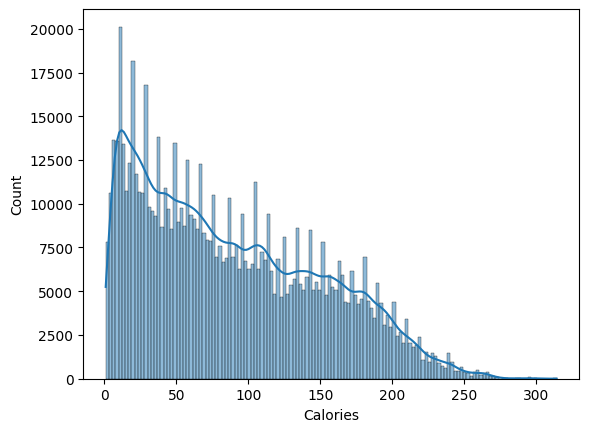

In [50]:
print("Skewness:", skew(train['Calories']))
sns.histplot(train['Calories'], kde=True)

log1p Skewness: -0.86


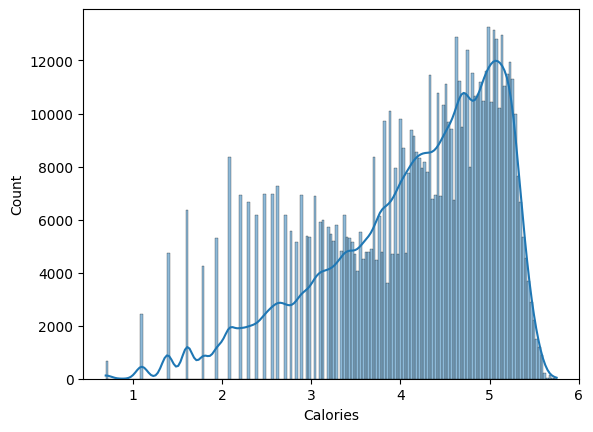

In [49]:
log_skew = skew(np.log1p(train['Calories']))
sns.histplot(np.log1p(train['Calories']), kde=True)
print(f"log1p Skewness: {log_skew:.2f}")

boxcox_skew : -0.15
Box-Cox lambda: 0.4388893456095887


<Axes: ylabel='Count'>

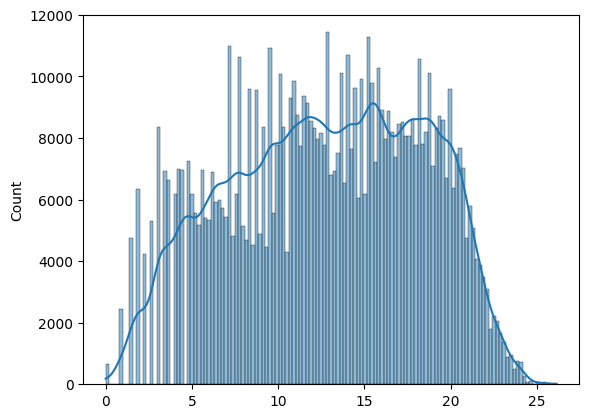

In [51]:
transformed, lambda_ = boxcox(train['Calories'] + 1e-3)

boxcox_skew = skew(transformed)
print(f"boxcox_skew : {boxcox_skew:.2f}")
print("Box-Cox lambda:", lambda_)
sns.histplot(transformed, kde=True)

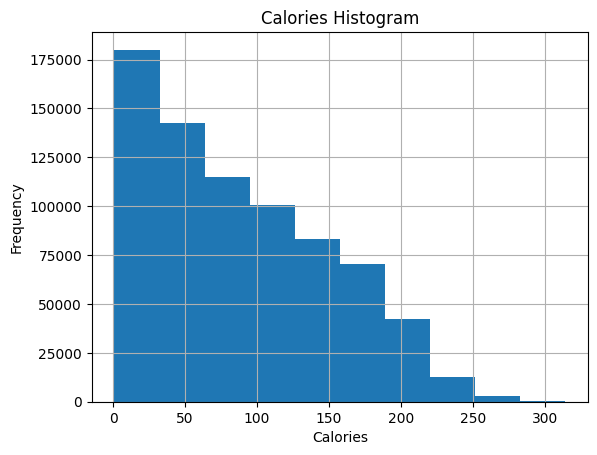

In [5]:
datamart[datamart['is_train'] == 1]['Calories'].hist()
plt.title("Calories Histogram")
plt.xlabel("Calories")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

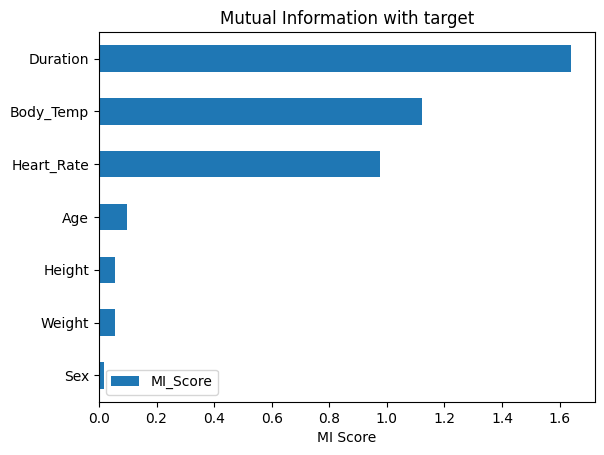

In [6]:
X = datamart[datamart['Calories'] > 0].drop(columns=["id","is_train","Calories"])
y = datamart[datamart['Calories'] > 0]["Calories"] 
mi = mutual_info_regression(X, y,random_state=CFG.seed)
mi = pd.Series(mi)
mi.index = X.columns
pd_mi = pd.DataFrame(mi.sort_values(ascending=False), columns=['MI_Score'])
pd_mi.plot.barh(title="Mutual Information with target")
plt.xlabel("MI Score")
plt.gca().invert_yaxis()
plt.show()

In [7]:
corr_data = datamart[datamart['is_train'] == 1][['Sex','Age','Height','Weight','Duration','Heart_Rate','Body_Temp','Calories']]
corr = corr_data.corr()
corr.style.background_gradient(cmap='coolwarm')

# Duration, Heart_rate ,Body_Temp(Body Temperature) has very high score

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
Sex,1.000000,0.009689,0.755906,0.818250,-0.009594,0.009122,-0.015933,0.012011
Age,0.009689,1.000000,0.011975,0.073690,0.015656,0.017037,0.030275,0.145683
Height,0.755906,0.011975,1.000000,0.957967,-0.029936,-0.013234,-0.034641,-0.004026
Weight,0.818250,0.073690,0.957967,1.000000,-0.020845,-0.002384,-0.023717,0.015863
Duration,-0.009594,0.015656,-0.029936,-0.020845,1.000000,0.875327,0.903066,0.959908
Heart_Rate,0.009122,0.017037,-0.013234,-0.002384,0.875327,1.000000,0.795972,0.908748
Body_Temp,-0.015933,0.030275,-0.034641,-0.023717,0.903066,0.795972,1.000000,0.828671
Calories,0.012011,0.145683,-0.004026,0.015863,0.959908,0.908748,0.828671,1.000000


# 2 Data Processing

In [8]:
# Calculate heart rate percentage based on HRmax
# Heart_Rate/(220-Age) * 100
# 50–60% HRmax: Light exercise (e.g., walking)
# 70–80% HRmax: Aerobic endurance training
# 85–95% HRmax: High-intensity interval training (HIIT)
datamart['HRP_based_HRmax'] = datamart['Heart_Rate']/(220-datamart['Age']) * 100

# Mifflin-St Jeor BMR calculation method
# for Man   : BMR = (10 × weight in kg)+(6.25 × height in cm)−(5 × age in years)+5
# for Woman : BMR = (10 × weight in kg)+(6.25 × height in cm)−(5 × age in years)−161
datamart['BMR'] = 10 * datamart['Weight'] + 6.25 * datamart['Height'] - 5 * datamart['Age'] + datamart['Sex'] * 166 - 161

In [9]:
def safe_rmsle(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [10]:
train_X = datamart[datamart['is_train'] == 1].drop(columns=["id","is_train","Calories"])
train_y = datamart[datamart['is_train'] == 1]["Calories"] 

In [11]:
def create_objective(ModelClass, param_space_func):
    def objective(trial):
        params = param_space_func(trial)
        model = ModelClass(**params)
        try:
            scores = cross_val_score(
                model, train_X, train_y,
                scoring=lambda m, X, y: safe_rmsle(y, m.predict(X)),
                cv=KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed),
                n_jobs=-1
            )
            return np.mean(scores)
        except Exception as e:
            return float('inf')
    return objective


def lgbm_param_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": CFG.seed
    }


def catboost_param_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "random_seed": CFG.seed,
        "verbose": 0
    }


def xgb_param_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "random_state": CFG.seed
    }

def HGBR_param_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "l2_regularization": trial.suggest_float("l2_regularization", 0.0, 5.0),
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "max_features": trial.suggest_float("max_features", 0.1, 1.0),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 20, 500),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 100),
        "random_state": CFG.seed,
        "early_stopping": True,
        "validation_fraction": 0.1,
        "n_iter_no_change": 10
    }


results = {}

for model_name, (ModelClass, param_func) in {
    "LGBM": (LGBMRegressor, lgbm_param_space),
    "CatBoost": (CatBoostRegressor, catboost_param_space),
    "XGBoost": (XGBRegressor, xgb_param_space),
    "HGBR": (HistGradientBoostingRegressor, HGBR_param_space)
}.items():
    print(f"🔍 {model_name} 튜닝 중...")
    study = optuna.create_study(direction="minimize")
    study.optimize(create_objective(ModelClass, param_func), n_trials=30, timeout=300)

    results[model_name] = {
        "best_value": study.best_value,
        "best_params": study.best_params,
    }

# 📢 결과 비교
print("\n✅ 성능 비교 (RMSLE 기준):")
for name, result in results.items():
    print(f"{name}: RMSLE = {result['best_value']:.5f}")

[I 2025-05-10 22:03:21,287] A new study created in memory with name: no-name-29f117fd-79eb-46c0-b8ce-65e7b6a5149c


🔍 LGBM 튜닝 중...


[I 2025-05-10 22:03:43,602] Trial 0 finished with value: 0.06516871324762605 and parameters: {'learning_rate': 0.04961929922714498, 'n_estimators': 245, 'num_leaves': 142, 'max_depth': 8, 'min_child_samples': 99, 'subsample': 0.7271555867497772, 'colsample_bytree': 0.5493235919937933}. Best is trial 0 with value: 0.06516871324762605.
[I 2025-05-10 22:04:47,711] Trial 1 finished with value: 0.06145994122130231 and parameters: {'learning_rate': 0.02645956797199005, 'n_estimators': 848, 'num_leaves': 171, 'max_depth': 19, 'min_child_samples': 43, 'subsample': 0.6646604419369293, 'colsample_bytree': 0.6604805037570379}. Best is trial 1 with value: 0.06145994122130231.
[I 2025-05-10 22:05:49,644] Trial 2 finished with value: 0.061385433595674346 and parameters: {'learning_rate': 0.0321067947028473, 'n_estimators': 824, 'num_leaves': 228, 'max_depth': 29, 'min_child_samples': 29, 'subsample': 0.9204946725248109, 'colsample_bytree': 0.7308659263095248}. Best is trial 2 with value: 0.061385433

🔍 CatBoost 튜닝 중...


[I 2025-05-10 22:10:28,368] Trial 0 finished with value: 0.06410792699701984 and parameters: {'learning_rate': 0.035928073461563084, 'depth': 6, 'l2_leaf_reg': 9.524860910620877, 'iterations': 968}. Best is trial 0 with value: 0.06410792699701984.
[I 2025-05-10 22:11:20,842] Trial 1 finished with value: 0.10366208611031862 and parameters: {'learning_rate': 0.015866043256247353, 'depth': 8, 'l2_leaf_reg': 3.344011869067459, 'iterations': 313}. Best is trial 0 with value: 0.06410792699701984.
[I 2025-05-10 22:13:05,896] Trial 2 finished with value: 0.0722396425445595 and parameters: {'learning_rate': 0.013825470514871607, 'depth': 6, 'l2_leaf_reg': 6.890266025659468, 'iterations': 813}. Best is trial 0 with value: 0.06410792699701984.
[I 2025-05-10 22:13:50,690] Trial 3 finished with value: 0.0744574164031124 and parameters: {'learning_rate': 0.030711688282590216, 'depth': 10, 'l2_leaf_reg': 6.229138450131174, 'iterations': 208}. Best is trial 0 with value: 0.06410792699701984.
[I 2025-0

🔍 XGBoost 튜닝 중...


[I 2025-05-10 22:16:39,818] Trial 0 finished with value: 0.1569337882824957 and parameters: {'learning_rate': 0.015500379435500752, 'n_estimators': 218, 'max_depth': 24, 'subsample': 0.6338267117695233, 'colsample_bytree': 0.5344225472973515, 'reg_alpha': 3.5118689343373384, 'reg_lambda': 4.20297533991088}. Best is trial 0 with value: 0.1569337882824957.
[I 2025-05-10 22:17:00,514] Trial 1 finished with value: 0.06789668043815036 and parameters: {'learning_rate': 0.08747240346759315, 'n_estimators': 250, 'max_depth': 5, 'subsample': 0.6117497143461463, 'colsample_bytree': 0.8944366852531992, 'reg_alpha': 3.153802659673225, 'reg_lambda': 0.08466844516558492}. Best is trial 1 with value: 0.06789668043815036.
[I 2025-05-10 22:26:49,789] Trial 2 finished with value: 0.06200768965391669 and parameters: {'learning_rate': 0.01694442445949834, 'n_estimators': 757, 'max_depth': 18, 'subsample': 0.7981190697287975, 'colsample_bytree': 0.8543999460586815, 'reg_alpha': 1.0784165576741884, 'reg_lam

🔍 HGBR 튜닝 중...


[I 2025-05-10 22:28:34,249] Trial 0 finished with value: 0.061647090246696554 and parameters: {'learning_rate': 0.017444251444238702, 'l2_regularization': 3.7683937717017435, 'max_depth': 26, 'max_features': 0.8384429651442864, 'max_iter': 866, 'max_leaf_nodes': 221, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.061647090246696554.
[I 2025-05-10 22:29:06,533] Trial 1 finished with value: 0.061822661281750055 and parameters: {'learning_rate': 0.08970499243903239, 'l2_regularization': 3.9136383093694658, 'max_depth': 24, 'max_features': 0.9142977063776744, 'max_iter': 554, 'max_leaf_nodes': 235, 'min_samples_leaf': 100}. Best is trial 0 with value: 0.061647090246696554.
[I 2025-05-10 22:29:41,500] Trial 2 finished with value: 0.06313435521524582 and parameters: {'learning_rate': 0.04664658025967447, 'l2_regularization': 3.1413395351879925, 'max_depth': 11, 'max_features': 0.9797540838818536, 'max_iter': 123, 'max_leaf_nodes': 476, 'min_samples_leaf': 100}. Best is trial 0 with v


✅ 성능 비교 (RMSLE 기준):
LGBM: RMSLE = 0.06139
CatBoost: RMSLE = 0.06411
XGBoost: RMSLE = 0.06201
HGBR: RMSLE = 0.06159


In [12]:
best_model_name = min(results, key=lambda k: results[k]['best_value'])
best_params = results[best_model_name]['best_params']

print(f"최종 선택 모델: {best_model_name}")

model_map = {
    "LGBM": lambda params: LGBMRegressor(**params),
    "CatBoost": lambda params: CatBoostRegressor(**params, verbose=0),
    "XGBoost": lambda params: XGBRegressor(**params),
    "HGBR": lambda params: HistGradientBoostingRegressor(**params)
}

최종 선택 모델: LGBM


In [17]:
final_model = model_map[best_model_name](best_params)

scores = cross_val_score(
    final_model, train_X, train_y,
    scoring=lambda m, X, y: np.sqrt(mean_squared_log_error(y, np.maximum(m.predict(X), 0))),
    cv=KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed),
    n_jobs=-1
)
print("Cross-validated RMSLE:", np.mean(scores))

Cross-validated RMSLE: 0.061347631417096024


In [26]:
final_model.fit(train_X, train_y)
y_pred = final_model.predict(train_X)
y_pred_clipped = np.maximum(y_pred, 0)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 9
[LightGBM] [Info] Start training from score 88.282781


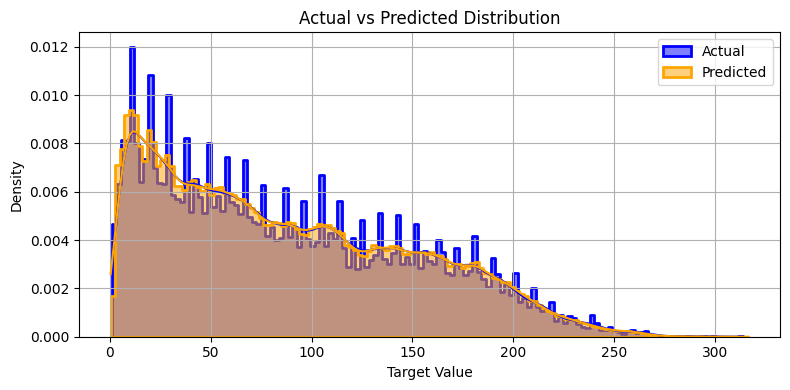

In [27]:
plt.figure(figsize=(8, 4))
sns.histplot(train_y, label="Actual", color="blue", kde=True, stat="density", element="step", linewidth=2)
sns.histplot(y_pred_clipped, label="Predicted", color="orange", kde=True, stat="density", element="step", linewidth=2)
plt.legend()
plt.title("Actual vs Predicted Distribution")
plt.xlabel("Target Value")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

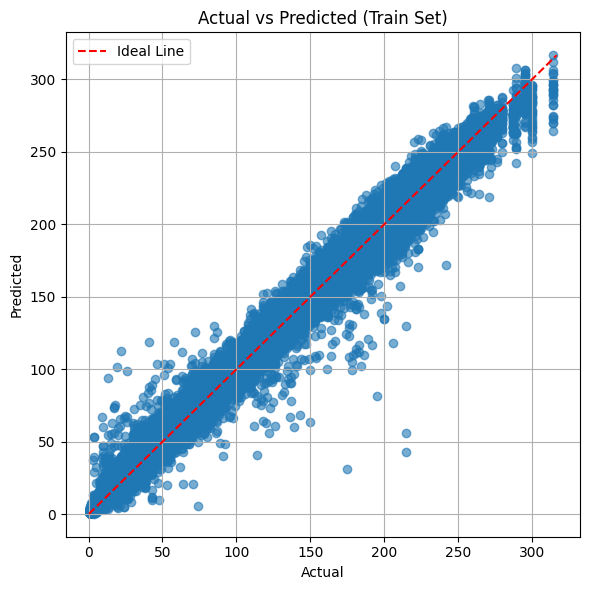

In [32]:
min_val = min(train_y.min(), y_pred_clipped.min())
max_val = max(train_y.max(), y_pred_clipped.max())

plt.figure(figsize=(6, 6))
plt.scatter(train_y, y_pred_clipped, alpha=0.6)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Line')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Train Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
submission_ids = datamart[datamart['is_train'] == 0]['id']

predictions = final_model.predict(datamart[datamart['is_train'] == 0].drop(columns=['id','Calories','is_train'])) 

predictions = np.maximum(predictions, 0)

submission = pd.DataFrame({
    "id": submission_ids,
    "Target": predictions
})


submission.to_csv("submission.csv", index=False)

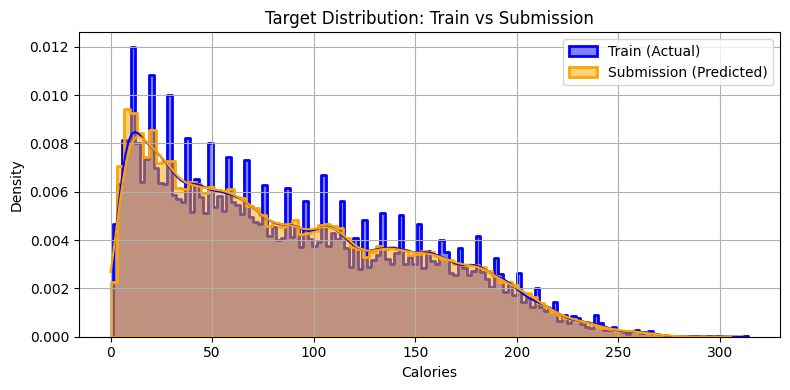

In [35]:
plt.figure(figsize=(8, 4))

sns.histplot(train['Calories'], label="Train (Actual)", color="blue", kde=True, stat="density", element="step", linewidth=2)

sns.histplot(submission['Target'], label="Submission (Predicted)", color="orange", kde=True, stat="density", element="step", linewidth=2)

plt.title("Target Distribution: Train vs Submission")
plt.xlabel("Calories")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()